In [1]:
import torch
from torch_geometric.datasets import Planetoid

def printInfo(dataset):
  print("Number of graphs:", len(dataset))
  print("Number of nodes:", dataset.data.x.size(dim=0))
  print("Number of edges:", dataset.data.edge_index.size(dim=1))
  print("Dimension of node features:", dataset.num_node_features)
  print("Number of classes:", dataset.num_classes)
  print("Average degree of nodes: {0:3f}".format(dataset.data.num_edges/dataset.data.num_nodes))
  print("Number of training nodes:", dataset.data.train_mask.sum().item())
  print("Number of validation nodes:", dataset.data.val_mask.sum().item())
  print("Number of test nodes:", dataset.data.test_mask.sum().item())
  
cite_seer = Planetoid(root='./CiteSeer', name='CiteSeer')
printInfo(cite_seer)

frequencies = {}
for i in range(6):
  frequencies[i+1] = (cite_seer.data.y[cite_seer.data.train_mask]==i).sum().item()
frequencies  

Number of graphs: 1
Number of nodes: 3327
Number of edges: 9104
Dimension of node features: 3703
Number of classes: 6
Average degree of nodes: 2.736399
Number of training nodes: 120
Number of validation nodes: 500
Number of test nodes: 1000


{1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20}

In [30]:
from numpy import inf
import numpy as np
from torch import nn
from torch.optim import Adam
from torch_geometric.nn import GCNConv, Sequential, GraphSAGE, GAT
import copy

dataset = cite_seer

def init(random_seed): 
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    
class GCN(nn.Module):
    def __init__(self, num_gcn_layers, num_neurons):
        super().__init__()
        self.num_gcn_layers = num_gcn_layers
        self.gcn_layers = []
        self.gcn_layers.append((GCNConv(dataset.num_node_features, num_neurons), 'x, edge_index -> x'))
        self.gcn_layers.append(nn.ReLU(inplace=True))
        #self.gcn_layers.append(nn.Dropout(0.2))

        for i in range(self.num_gcn_layers-1):
            self.gcn_layers.append((GCNConv(num_neurons, num_neurons), 'x, edge_index -> x'))
            self.gcn_layers.append(nn.ReLU(inplace=True))
            #self.gcn_layers.append(nn.Dropout(0.2))
        self.gcn_layers.append(nn.Linear(num_neurons, dataset.num_classes))  

        self.gcn_sequential = Sequential('x, edge_index', self.gcn_layers)
    
    def forward(self, data):
        x = self.gcn_sequential(data.x, data.edge_index)
        return x
    
class GRAPHSAGE(nn.Module):
    def __init__(self, num_hidden_channels, num_layers):
        super().__init__()
        self.graphsage = GraphSAGE(dataset.num_node_features, num_hidden_channels, num_out_channels=num_hidden_channels ,num_layers=num_layers)
        self.linear = nn.Linear(num_hidden_channels, dataset.num_classes)
    
    def forward(self, data):
        return self.linear(self.graphsage(data.x, data.edge_index))

class GAT2(nn.Module):
    def __init__(self, num_hidden_channels, num_layers):
        super().__init__()
        self.gat = GAT(dataset.num_node_features, num_hidden_channels, num_out_channels=dataset.num_classes ,num_layers=num_layers)
        
    def forward(self, data):
        return self.gat(data.x, data.edge_index)
    
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def train(type, epochs, lr, num_layers, num_hidden_channels, loss_fn):
    random_seed = 49
    init(random_seed)
    
    if type=='gcn':
        model = GCN(num_gcn_layers=num_layers, num_neurons=num_hidden_channels).to(device)
    elif type=='sage':
        model=GRAPHSAGE(num_hidden_channels, num_layers=num_layers).to(device)
    elif type=='gat':
        model=GAT2(num_hidden_channels, num_layers=num_layers).to(device)   
        
    optimizer = Adam(model.parameters(), lr=lr)
    softmax_func = nn.Softmax(dim=1)
    current = 1
    history = {'train_loss' : [], 'val_loss' : [], 'train_acc': [], 'val_acc' : []}
    val_min_loss = inf
    best_model = None
    model.train()
    while current <= epochs:
        print(f'Epoch {current}/{epochs}:')
        model.zero_grad()
        data  = dataset[0].to(device)
        out = softmax_func(model(data))
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
        val_loss = loss_fn(out[data.val_mask], data.y[data.val_mask])
        history['train_loss'].append(loss.item())
        history['val_loss'].append(val_loss.item())
        preds = out.argmax(dim=1)
        history['train_acc'].append(int((preds[data.train_mask]==data.y[data.train_mask]).sum())/int(data.train_mask.sum()))
        history['val_acc'].append(int((preds[data.val_mask]==data.y[data.val_mask]).sum())/int(data.val_mask.sum()))
        print(f'Traning loss: {loss.item():0.5f}')
        print(f'Validation loss: {val_loss.item():0.5f}')
        print(10*'-')
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        if val_loss.item() < val_min_loss:
            val_min_loss = val_loss.item()
            best_model = copy.deepcopy(model)
        current += 1    
    return best_model, history

def test(model, loss_fn):
    softmax_func = nn.Softmax(dim=1)
    model.eval()
    with torch.no_grad():
        data  = dataset[0].to(device)
        out = softmax_func(model(data))
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask]).item()
        val_loss = loss_fn(out[data.val_mask], data.y[data.val_mask]).item()
        test_loss = loss_fn(out[data.test_mask], data.y[data.test_mask]).item()
        preds = out.argmax(dim=1)
        print(f'Training loss: {loss:0.5f}')
        print(f'Accuracy on training set: {int((preds[data.train_mask]==data.y[data.train_mask]).sum())/int(data.train_mask.sum()):0.4f}')
        print('-'*10)
        print(f'Validation loss: {val_loss:0.5f}')
        print(f'Accuracy on validation set: {int((preds[data.val_mask]==data.y[data.val_mask]).sum())/int(data.val_mask.sum()):0.4f}')
        print('-'*10)
        print(f'Test loss: {test_loss:0.5f}')
        print(f'Accuracy on training set: {int((preds[data.test_mask]==data.y[data.test_mask]).sum())/int(data.test_mask.sum()):0.4f}')

## Loss functions

In [3]:
def CE(y_hat, y):
    return torch.sum(-1*torch.log(y_hat[range(y.size()[0]), y.long()])) / y.size()[0]

def RJM(y_hat, y):
    return torch.sum(1 - torch.sqrt(y_hat[range(y.size()[0]), y.long()])) / y.size()[0]

## GAT

In [33]:
best_model, history = train('gat', 200, 0.001, 2, 64, CE)

Epoch 1/200:
Traning loss: 4.17119
Validation loss: 4.17306
----------
Epoch 2/200:
Traning loss: 4.10036
Validation loss: 4.12678
----------
Epoch 3/200:
Traning loss: 4.03295
Validation loss: 4.08227
----------
Epoch 4/200:
Traning loss: 3.96660
Validation loss: 4.03794
----------
Epoch 5/200:
Traning loss: 3.89895
Validation loss: 3.99202
----------
Epoch 6/200:
Traning loss: 3.82785
Validation loss: 3.94337
----------
Epoch 7/200:
Traning loss: 3.75246
Validation loss: 3.89160
----------
Epoch 8/200:
Traning loss: 3.67254
Validation loss: 3.83654
----------
Epoch 9/200:
Traning loss: 3.58808
Validation loss: 3.77793
----------
Epoch 10/200:
Traning loss: 3.49892
Validation loss: 3.71573
----------
Epoch 11/200:
Traning loss: 3.40503
Validation loss: 3.65005
----------
Epoch 12/200:
Traning loss: 3.30657
Validation loss: 3.58095
----------
Epoch 13/200:
Traning loss: 3.20384
Validation loss: 3.50874
----------
Epoch 14/200:
Traning loss: 3.09705
Validation loss: 3.43347
----------
E

In [34]:
test(best_model, CE)

Training loss: 0.09934
Accuracy on training set: 0.9917
----------
Validation loss: 1.20693
Accuracy on validation set: 0.6240
----------
Test loss: 1.21214
Accuracy on training set: 0.6210


In [36]:
best_model2, history2 = train('gat', 200, 0.001, 2, 64, RJM)

Epoch 1/200:
Traning loss: 0.87571
Validation loss: 0.87582
----------
Epoch 2/200:
Traning loss: 0.87122
Validation loss: 0.87290
----------
Epoch 3/200:
Traning loss: 0.86677
Validation loss: 0.87001
----------
Epoch 4/200:
Traning loss: 0.86222
Validation loss: 0.86705
----------
Epoch 5/200:
Traning loss: 0.85741
Validation loss: 0.86390
----------
Epoch 6/200:
Traning loss: 0.85215
Validation loss: 0.86046
----------
Epoch 7/200:
Traning loss: 0.84633
Validation loss: 0.85669
----------
Epoch 8/200:
Traning loss: 0.83988
Validation loss: 0.85254
----------
Epoch 9/200:
Traning loss: 0.83273
Validation loss: 0.84795
----------
Epoch 10/200:
Traning loss: 0.82479
Validation loss: 0.84289
----------
Epoch 11/200:
Traning loss: 0.81597
Validation loss: 0.83732
----------
Epoch 12/200:
Traning loss: 0.80618
Validation loss: 0.83121
----------
Epoch 13/200:
Traning loss: 0.79534
Validation loss: 0.82451
----------
Epoch 14/200:
Traning loss: 0.78334
Validation loss: 0.81718
----------
E

In [37]:
test(best_model2, RJM)

Training loss: 0.02190
Accuracy on training set: 0.9917
----------
Validation loss: 0.35956
Accuracy on validation set: 0.6300
----------
Test loss: 0.36402
Accuracy on training set: 0.6240


## Test

In [38]:
from sklearn.metrics import f1_score
def test2(model, loss_fn):
    softmax_func = nn.Softmax(dim=1)
    model.eval()
    with torch.no_grad():
        data  = dataset[0].to(device)
        out = softmax_func(model(data))
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask]).item()
        val_loss = loss_fn(out[data.val_mask], data.y[data.val_mask]).item()
        test_loss = loss_fn(out[data.test_mask], data.y[data.test_mask]).item()
        preds = out.argmax(dim=1)
        preds_val = preds[data.val_mask].detach().cpu().numpy()
        preds_test = preds[data.test_mask].detach().cpu().numpy()
        data_y_val = data.y[data.val_mask].detach().cpu().numpy()
        data_y_test = data.y[data.test_mask].detach().cpu().numpy()
        print(f'Training loss: {loss:0.5f}')
        print(f'Accuracy on training set: {int((preds[data.train_mask]==data.y[data.train_mask]).sum())/int(data.train_mask.sum()):0.4f}')
        print('-'*10)
        print(f'Validation loss: {val_loss:0.5f}')
        print(f'Accuracy on validation set: {int((preds[data.val_mask]==data.y[data.val_mask]).sum())/int(data.val_mask.sum()):0.4f}')
        print(f'F1 on val set: {f1_score(data_y_val, preds_val, average="macro"):0.4f}')
        print('-'*10)
        print(f'Test loss: {test_loss:0.5f}')
        print(f'Accuracy on training set: {int((preds[data.test_mask]==data.y[data.test_mask]).sum())/int(data.test_mask.sum()):0.4f}')
        print(f'F1 on test set: {f1_score(data_y_test, preds_test, average="macro"):0.4f}')

In [39]:
test2(best_model, CE)

Training loss: 0.09934
Accuracy on training set: 0.9917
----------
Validation loss: 1.20693
Accuracy on validation set: 0.6240
F1 on val set: 0.6020
----------
Test loss: 1.21214
Accuracy on training set: 0.6210
F1 on test set: 0.5972


In [40]:
test2(best_model2, RJM)

Training loss: 0.02190
Accuracy on training set: 0.9917
----------
Validation loss: 0.35956
Accuracy on validation set: 0.6300
F1 on val set: 0.6096
----------
Test loss: 0.36402
Accuracy on training set: 0.6240
F1 on test set: 0.5991


## Visualization

In [61]:
import matplotlib.pyplot as plt
#0BA51F
#DA9D05
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

def plotLoss(epochs, training_loss, val_loss):
    cm = 1/2.54
    fig1 = plt.figure(figsize=(15*cm,10*cm), dpi=300)
    ax = fig1.subplots(1)
    ax.plot(epochs, training_loss, label='Training loss', c='#D35400')
    ax.plot(epochs, val_loss, label='Validation loss', c='#7D3C98')
    ax.set_xticks(range(50,201,50))
    ax.grid()
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(prop = {'size' : 15})
    plt.show()

def plotGE(epochs, GE1, GE2):
    cm = 1/2.54
    fig1 = plt.figure(figsize=(15*cm,10*cm), dpi=300)
    ax = fig1.subplots(1)
    ax.plot(epochs, GE1, label='CE', c='b')
    ax.plot(epochs, GE2, label='RJM', c='r')
    ax.set_xticks(range(50, 201, 50))
    ax.grid()
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('$\hat{E}(f_{B_S,R})$', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(prop = {'size' : 15})
    plt.show()


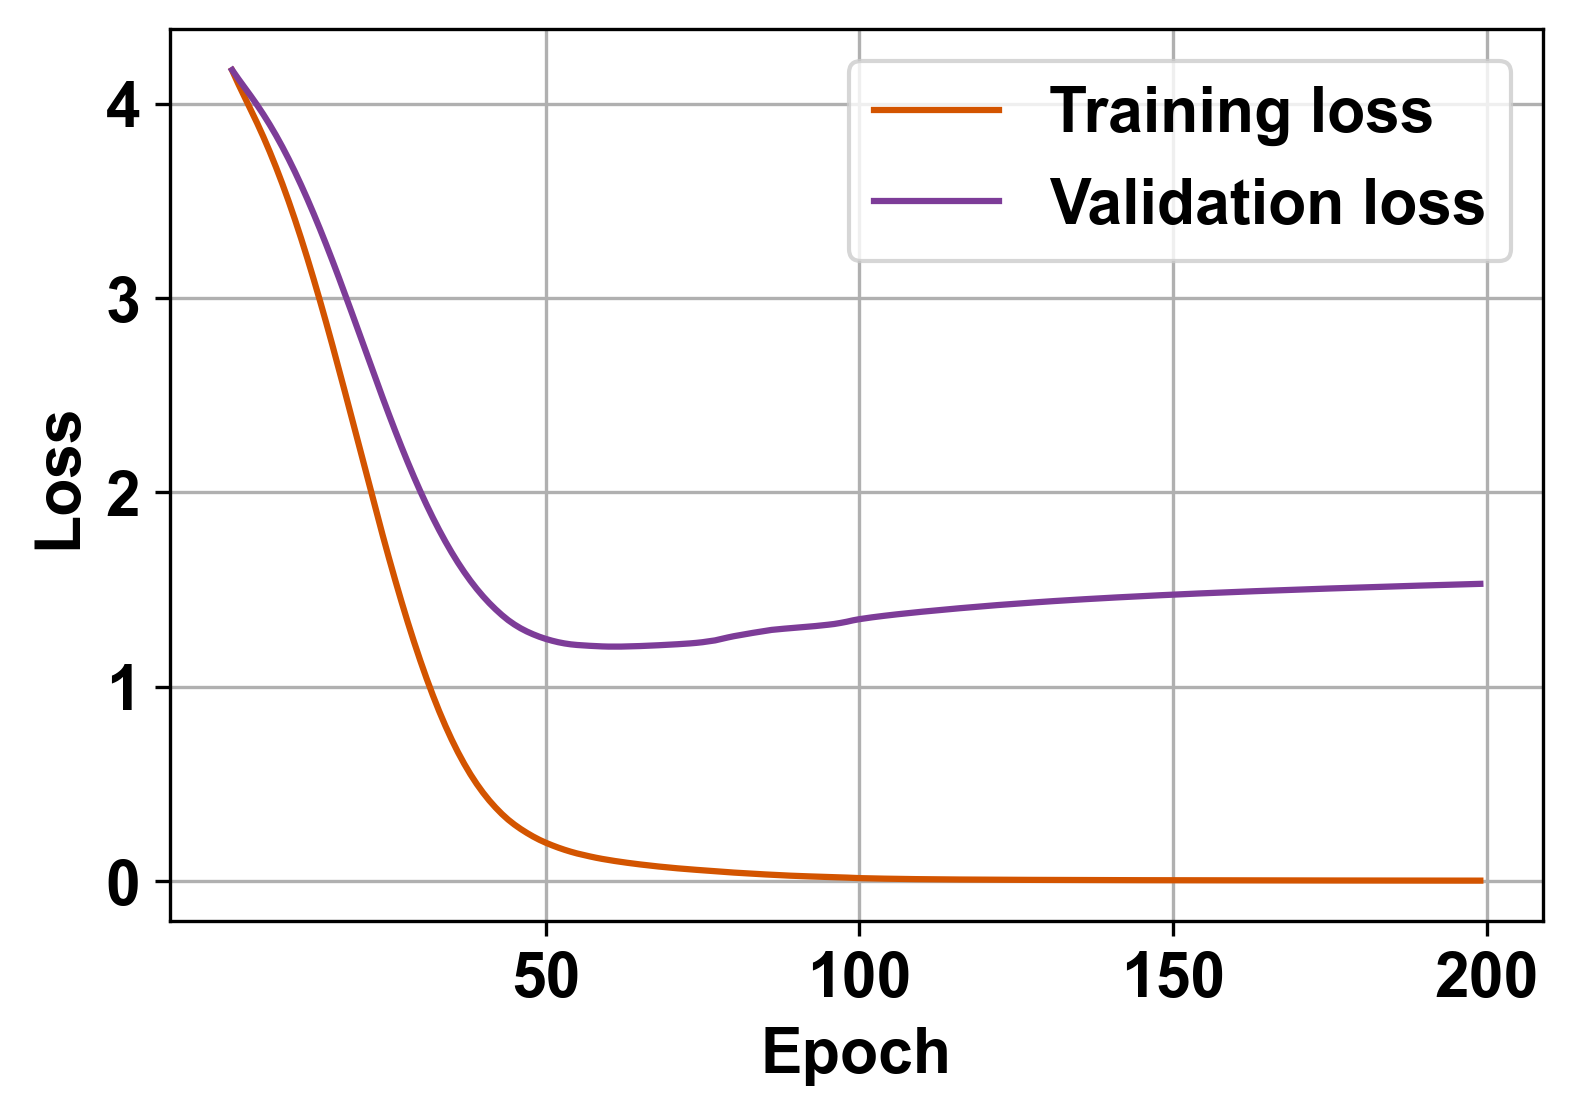

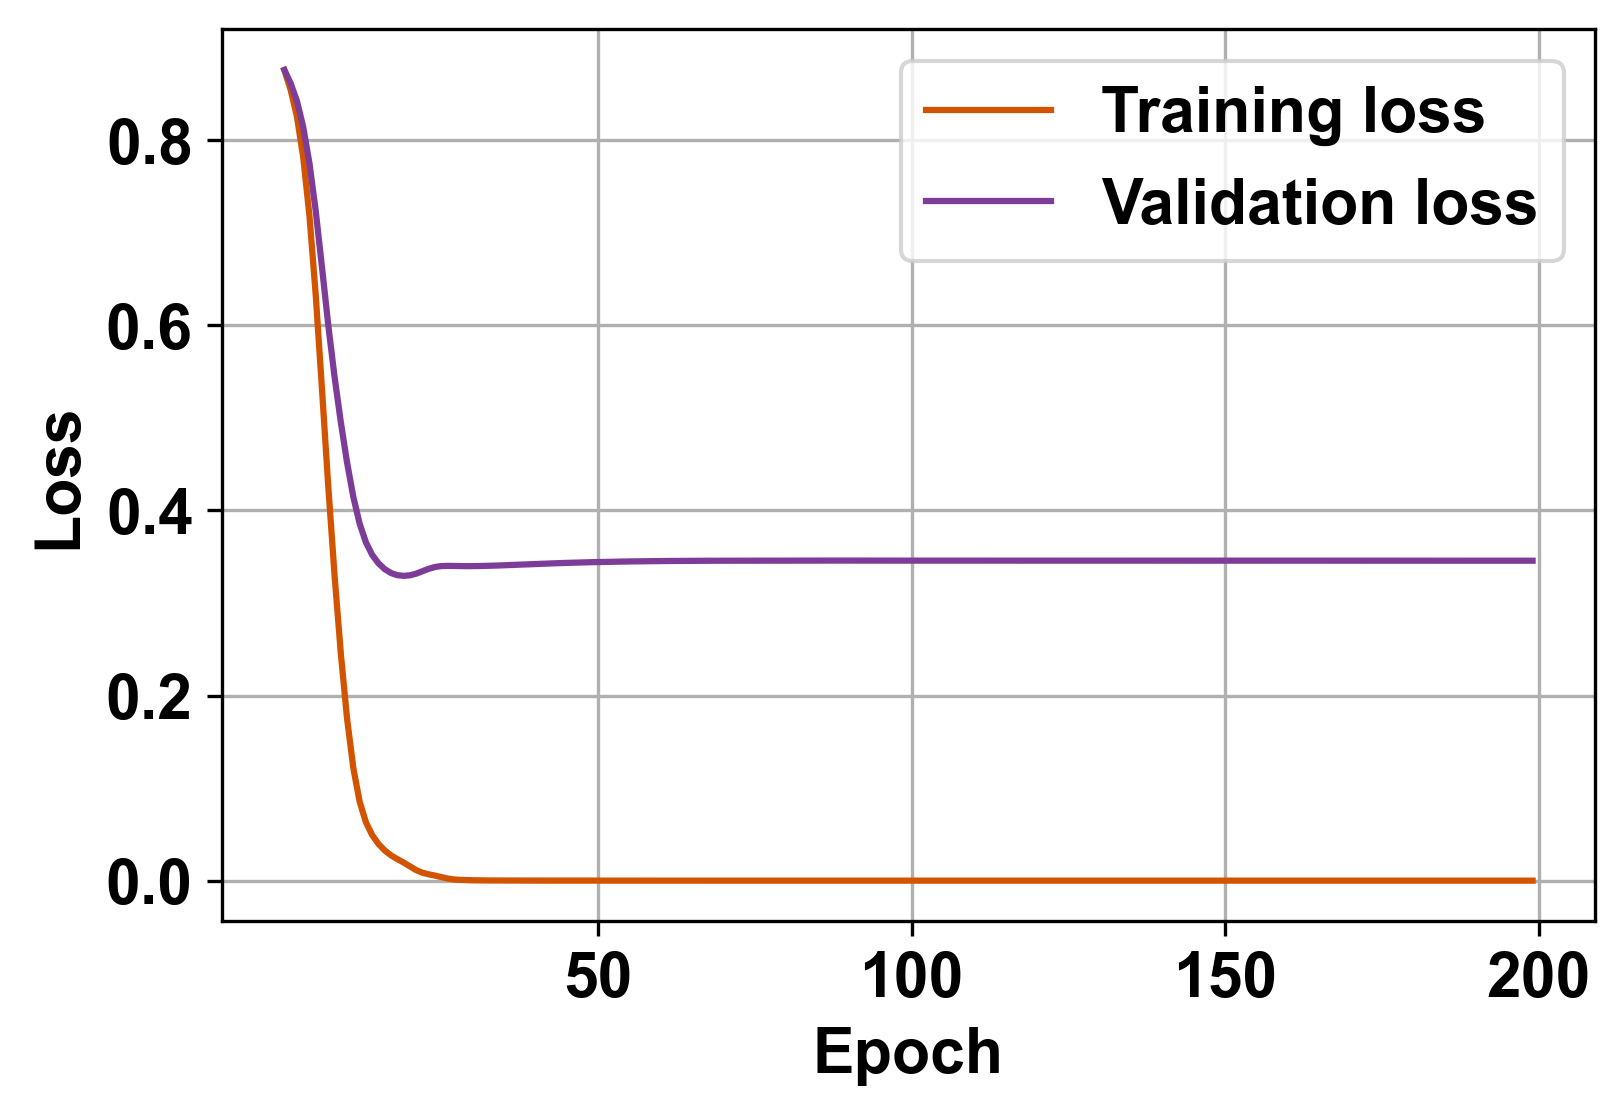

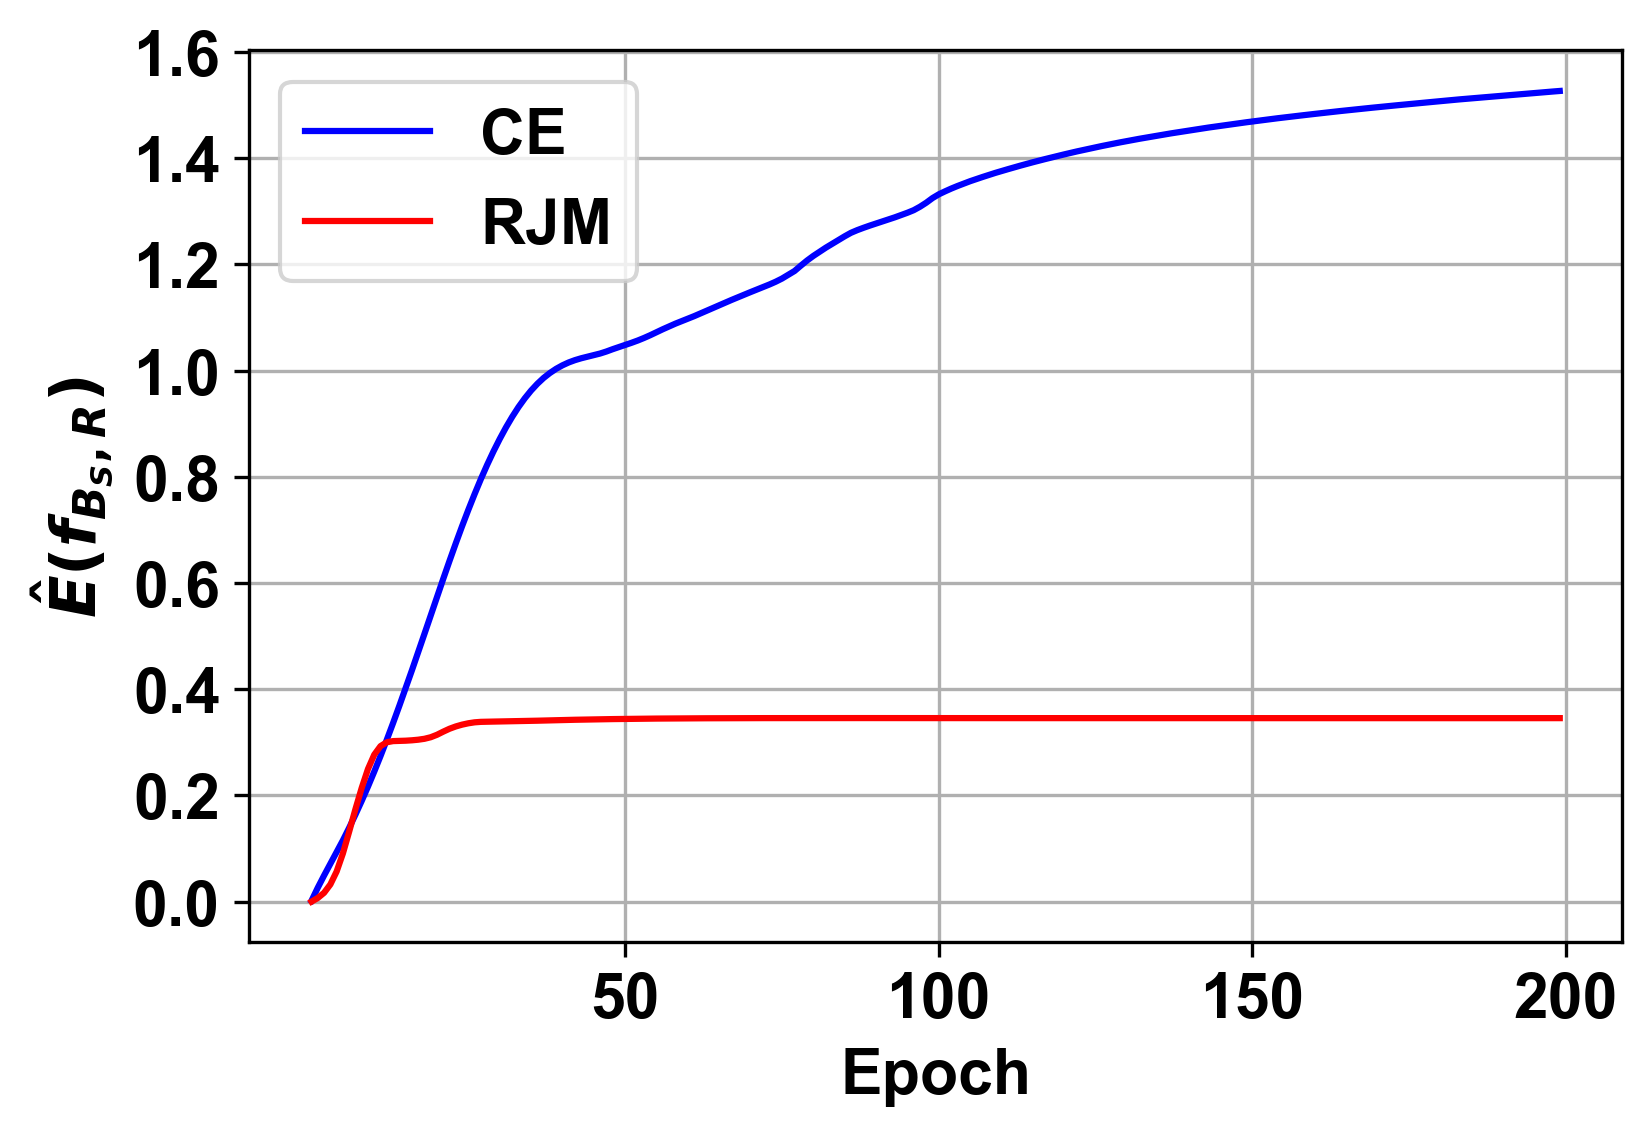

In [62]:
GE_ce = list(map(lambda x: abs(x[0]-x[1]), zip(history['train_loss'], history['val_loss'])))
GE_rjm = list(map(lambda x: abs(x[0]-x[1]), zip(history2['train_loss'], history2['val_loss'])))
epochs = range(0,200)
plotLoss(epochs, history['train_loss'], history['val_loss'])
plotLoss(epochs, history2['train_loss'], history2['val_loss'])
plotGE(epochs, GE_ce, GE_rjm)